In [2]:
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from keras.metrics import Precision, Recall
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Embedding,
    Bidirectional,
    Dropout,
    GlobalMaxPooling1D,
    Concatenate,
    BatchNormalization,
    Conv1D,
    ReLU,
    Input,
    GRU,
)
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.metrics import confusion_matrix
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras import regularizers
from keras.layers import Embedding, Flatten, Dense
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk import word_tokenize, pos_tag, ne_chunk
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from datetime import datetime

2024-02-02 23:48:11.760298: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/rusab1/Work/Personal_Projects/learntorch/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
games = pd.read_csv("datasets/unprocessed_data/steam_recommendation/games.csv")
users = pd.read_csv(
    "datasets/unprocessed_data/steam_recommendation/users.csv").head()
recommendations = pd.read_csv(
    "datasets/unprocessed_data/steam_recommendation/recommendations.csv"
)

games, users

In [6]:
main_df = recommendations.merge(games, on="app_id")

In [7]:
train_dataset = main_df[
    [
        "is_recommended",
        "helpful",
        "funny",
        "hours",
        "positive_ratio",
        "rating",
        "linux",
        "mac",
        "win",
        "price_final",
        "price_original",
        "discount",
        "app_id",
    ]
]
train_dataset.columns

Index(['is_recommended', 'helpful', 'funny', 'hours', 'positive_ratio',
       'rating', 'linux', 'mac', 'win', 'price_final', 'price_original',
       'discount', 'app_id'],
      dtype='object')

In [ ]:
main_df.drop(columns=["review_id", "user_id",
             "date", "app_id", "user"], inplace=True)

In [8]:
arr = ["is_recommended", "linux", "mac", "win"]
train_dataset["rating"] = LabelEncoder().fit_transform(train_dataset["rating"])
for columns in arr:
    train_dataset[columns] = to_categorical(train_dataset[columns])

train_dataset.dropna(inplace=True)
train_dataset

/var/folders/mc/529dnmr107lbrjvk8tdft4y00000gq/T/ipykernel_96228/1719737818.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset['rating'] = LabelEncoder().fit_transform(train_dataset['rating'])
/var/folders/mc/529dnmr107lbrjvk8tdft4y00000gq/T/ipykernel_96228/1719737818.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_dataset[columns] = to_categorical(train_dataset[columns])
/var/folders/mc/529dnmr107lbrjvk8tdft4y00000gq/T/ipykernel_96228/1719737818.py:6: SettingWithCopyWarning: 
A val

,is_recommended,helpful,funny,hours,positive_ratio,rating,linux,mac,win,price_final,price_original,discount,app_id
0,0.0,0,0,36.3,95,5,0.0,1.0,1.0,30.00,0.00,0.0,975370
1,0.0,0,0,24.3,95,5,0.0,1.0,1.0,30.00,0.00,0.0,975370
2,0.0,3,0,177.0,95,5,0.0,1.0,1.0,30.00,0.00,0.0,975370
3,0.0,5,0,388.6,95,5,0.0,1.0,1.0,30.00,0.00,0.0,975370
4,0.0,0,0,70.1,95,5,0.0,1.0,1.0,30.00,0.00,0.0,975370
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41154789,0.0,4,0,13.0,87,8,0.0,1.0,1.0,7.49,14.99,50.0,1643850
41154790,0.0,0,0,18.0,87,8,0.0,1.0,1.0,7.49,14.99,50.0,1643850
41154791,0.0,0,0,6.0,87,8,0.0,1.0,1.0,7.49,14.99,50.0,1643850
41154792,0.0,0,0,5.0,87,8,0.0,1.0,1.0,7.49,14.99,50.0,1643850


In [57]:
model = Sequential()
model.add(Dense(256, activation="relu", input_shape=(12,)))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss="binary_crossentropy",
              metrics=["accuracy"])

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_df = scaler.fit_transform(df)

In [9]:
# train_dataset = train_dataset.astype('float32')
# train_dataset.dtypes
np.savez_compressed(
    "datasets/preprocessed_data/steam_game_recommendation/train_dataset.npz",
    data_1=train_dataset,
    columns=train_dataset.columns,
)

In [64]:
load = np.load(
    "datasets/preprocessed_data/steam_game_recommendation/train_dataset.npz",
    allow_pickle=True,
)
load.files
data = load["data_1"]
columns = load["columns"]
# data
df = pd.DataFrame(data, columns=columns)
df_true = df[df["is_recommended"] == 1].tail(1500000)
df_false = df[df["is_recommended"] == 0].tail(1500000)
df = pd.concat([df_true, df_false])
df_true = None
df_false = None
# df1 = df.head(500000)
# df2 = df.tail(500000)
# df = df1.merge(df2, how='outer')
df1 = None
df2 = None
load = None
data = None
columns = None
# train_dataset

In [65]:
real_label = df["is_recommended"]
real_label
df.drop(columns=["is_recommended"], inplace=True)
df

,helpful,funny,hours,positive_ratio,rating,linux,mac,win,price_final,price_original,discount,app_id
32909980,0.0,0.0,2.3,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
32910011,2.0,0.0,0.2,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
32910049,0.0,0.0,3.0,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
32910058,0.0,0.0,4.2,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
32910070,3.0,0.0,2.4,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
...,...,...,...,...,...,...,...,...,...,...,...,...
41154789,4.0,0.0,13.0,87.0,8.0,0.0,1.0,1.0,7.49,14.99,50.0,1643850.0
41154790,0.0,0.0,18.0,87.0,8.0,0.0,1.0,1.0,7.49,14.99,50.0,1643850.0
41154791,0.0,0.0,6.0,87.0,8.0,0.0,1.0,1.0,7.49,14.99,50.0,1643850.0
41154792,0.0,0.0,5.0,87.0,8.0,0.0,1.0,1.0,7.49,14.99,50.0,1643850.0


In [58]:
model.fit(train_df, real_label, epochs=3, validation_split=0.3)

Epoch 1/3
65625/65625 [==============================] - 169s 3ms/step - loss: 0.0010 - accuracy: 0.9999 - val_loss: 1.9314e-04 - val_accuracy: 1.0000
Epoch 2/3
65625/65625 [==============================] - 166s 3ms/step - loss: 3.2722e-05 - accuracy: 1.0000 - val_loss: 1.4474e-08 - val_accuracy: 1.0000
Epoch 3/3
65625/65625 [==============================] - 171s 3ms/step - loss: 1.8437e-16 - accuracy: 1.0000 - val_loss: 1.3809e-08 - val_accuracy: 1.0000


In [59]:
model.save("models/steam_recommendation_model.h5")

/Users/rusab1/Work/Personal_Projects/learntorch/venv/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [62]:
df.drop(columns=["is_recommended"], inplace=True)
df

,helpful,funny,hours,positive_ratio,rating,linux,mac,win,price_final,price_original,discount,app_id
32909980,0.0,0.0,2.3,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
32910011,2.0,0.0,0.2,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
32910049,0.0,0.0,3.0,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
32910058,0.0,0.0,4.2,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
32910070,3.0,0.0,2.4,92.0,8.0,0.0,1.0,0.0,0.99,0.99,0.0,263980.0
...,...,...,...,...,...,...,...,...,...,...,...,...
41154789,4.0,0.0,13.0,87.0,8.0,0.0,1.0,1.0,7.49,14.99,50.0,1643850.0
41154790,0.0,0.0,18.0,87.0,8.0,0.0,1.0,1.0,7.49,14.99,50.0,1643850.0
41154791,0.0,0.0,6.0,87.0,8.0,0.0,1.0,1.0,7.49,14.99,50.0,1643850.0
41154792,0.0,0.0,5.0,87.0,8.0,0.0,1.0,1.0,7.49,14.99,50.0,1643850.0


In [66]:
df_scalar = scaler.fit_transform(df)

In [77]:
predicted_labels = model.predict(df_scalar)

93750/93750 [==============================] - 127s 1ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       ...,
       [1.4715738e-17],
       [1.5225146e-17],
       [9.7822115e-18]], dtype=float32)

In [85]:
final = []
for a in predicted_labels:
    if a < 0.5:
        final.append(0)
    else:
        final.append(1)

Shape of Confusion Matrix: (2, 2)


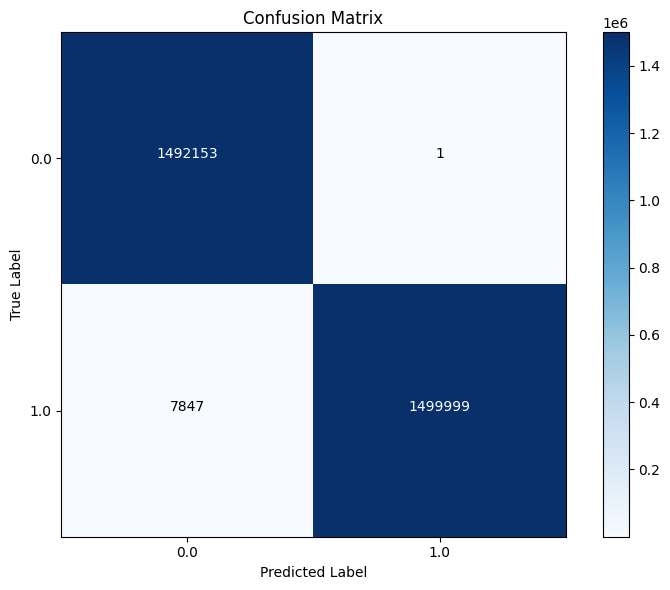

In [86]:
cm = confusion_matrix(final, real_label)

# Identify misclassifications with counts greater than 1
misclassified_indices = np.where(cm > 0)

# Display the confusion matrix and its shape
# print("Confusion Matrix:")
# print(cm)
print("Shape of Confusion Matrix:", cm.shape)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))

# Define colors for the plot
cmap = plt.cm.Blues
# Set the color for misclassifications
cmap.set_under("green")

plt.imshow(cm, interpolation="nearest", cmap=cmap, vmin=0.1)
plt.title("Confusion Matrix")
plt.colorbar()

# Adding axis labels
classes = np.unique(real_label)
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Adding annotations for misclassifications with counts > 1
thresh = cm.max() / 2.0
for i, j in zip(*misclassified_indices):
    plt.text(
        j,
        i,
        format(cm[i, j], "d"),
        horizontalalignment="center",
        color="white" if cm[i, j] > thresh else "black",
    )

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()